# Implémentation de l'algorithme Affinity Propagation

Dans ce notebook, nous allons implémenter l'algorithme étudié dans son cadre "classique", c'est à dire non distribué. Il repose sur l'article suivant : Clustering by Passing Messages Between Data Points [Brendan J. Frey* and Delbert Dueck, 2007] (http://www.icmla-conference.org/icmla07/FreyDueckScience07.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Générons les données d'entrainement.

In [2]:
N = 10
x_1 = np.random.multivariate_normal(mean=[0,0], cov=[[0.1,0],[0,0.1]], size=N)
x_2 = np.random.multivariate_normal(mean=[3,0], cov=[[0.3,-0.1],[-0.1,0.2]], size=N)
x_3 = np.random.multivariate_normal(mean=[0,3], cov=[[0.2,0],[0,0.2]], size=N)
N = 3*N
X = np.concatenate((x_1, x_2, x_3))

Affichons les pour vérifier qu'on peut distinguer "à l'oeil" les trois clusters.

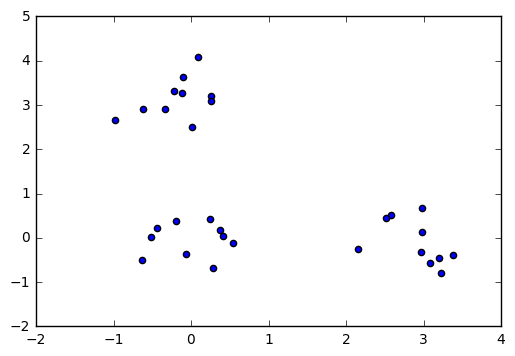

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()

On définit la mesure de similarité S, qui s'exprime comme une matrice (symmétrique, la métrique utilisée étant la mesure euclidienne).

In [4]:
S = np.zeros(shape=[N,N])
for i in range(0,N):
    for j in range(0,N):
        S[i,j] = -np.linalg.norm(X[i]-X[j]) ** 2
        
for k in range(0,N):
    S[k,k] = np.median([S[i,j] for i in range(0,N) for j in range(0,N) if i!=j])

Affichons un extrait de cette matrice pour vérifier que :
- elle est bien symmétrique
- les valeurs sont négatives
- la diagonale est constante (aucun point n'est à priori priviligié)

In [5]:
S[1:5,1:5]

array([[-8.72456454, -0.39183994, -0.43228277, -0.04586499],
       [-0.39183994, -8.72456454, -0.72325018, -0.17332128],
       [-0.43228277, -0.72325018, -8.72456454, -0.39763608],
       [-0.04586499, -0.17332128, -0.39763608, -8.72456454]])

On implémente donc les opérations qui doivent être itérativement appliquées aux matrices A et R (Afffinity et Responsibility).

In [6]:
lbda = 0.5

def perform_iteration(A,R):
    for i in range(0,N):
        for k in range(0,N):
            updateValue = S[i,k] - np.max([A[i,kprime] + S[i,kprime] for kprime in range(0,N) if kprime != k])
            R[i,k] = (1-lbda) * updateValue + lbda * R[i,k]
             

    for i in range(0,N):
        for k in range(0,N):
            if i == k:
                value = np.sum([max(0, R[iprime,k]) for iprime in range(0,N) if iprime != k])
                A[i,k] = (1-lbda) * value + lbda * A[i,k]
            else:
                value = min(0,np.sum([max(0, R[iprime,k]) for iprime in range(0,N) if iprime != k and iprime != i]) + R[k,k])
                A[i,k] = (1-lbda) * value + lbda * A[i,k]
                
    return (A,R)

On initialise les matrices à A et R à zéros, puis on lance 100 itérations

In [7]:
A = np.zeros(shape=[N,N])
R = np.zeros(shape=[N,N])

for i in range(100):
    (A,R) = perform_iteration(A,R)

On récupère les individu qui satisfont R[i,i] + A[i,i] > 0

In [8]:
[(i,R[i,i]+A[i,i]) for i in range(0,N) if R[i,i]+A[i,i]>0]

[(3, 58.527543444469508), (18, 56.973849063414569), (23, 65.818820052901557)]

On affiche les resultats

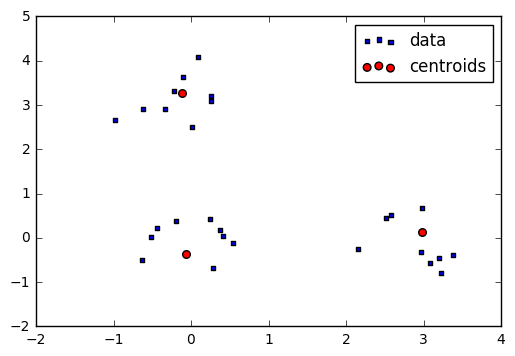

In [9]:
idx = [i for i in range(0,N) if R[i,i]+A[i,i]>0]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X[:,0], X[:,1], s=10, c='b', marker="s", label='data')
ax1.scatter(X[idx,0],X[idx,1], s=30, c='r', marker="o", label='centroids')
plt.legend(loc='upper right');
plt.show()

Ca marche !

# Utilisation (et vérification des résultats) avec scikit-learn

Scikit-learn propose une implémentation de cet algorithme. Essayons la.

In [10]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation().fit(X)

In [11]:
af

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [12]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

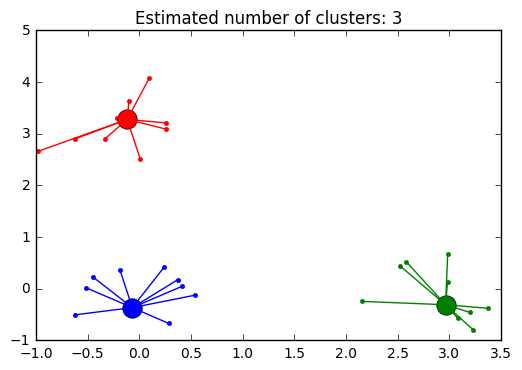

In [13]:
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

On obtient bien les mêmes centres.